# WEB SCRAPING + APIs PROJECT

## Description

Creator: Luis Farre
Date: 20/02/2020

Description: El objetivo de este proyecto es obtener los datos necesarios 
para entender si existe una correlacion entre la cotizacion de las acciones 
de una empresa con la facturacion de esta.

Para ello hemos sacado informacion sobre los resultados de www.investing.com
Y hemos utilizado la api www.financialmodelingprep.com para obtener la evolucion de la cotizacion.


## Imports

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import base64
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import ticker
import ipywidgets as widgets
from IPython.display import display
import re
import time
from selenium import webdriver

## Web Scraping

### Scrap Unites States 50 Companies

In [2]:
url='https://investing.com/equities'
headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36'}

html=requests.get(url,headers=headers).content
soup=BeautifulSoup(html,'lxml')

table = soup.find_all('table',{'id':'cross_rate_markets_stocks_1'})

In [3]:
table2=table[0]

In [4]:
rows=table2.find_all('tr')
rows=rows[1:]

In [5]:
titles = [row.a.get('title') for row in rows]
links = [row.a.get('href') for row in rows]

Diccionario con todas las empresas del IBEX

### Widget to be able to choose the company to Study

In [6]:
dict_companies = { titles[i] : links[i] for i in range(len(titles)) }

In [7]:
companies_dropdown=widgets.Dropdown(options=titles,description='Company:')
companies_dropdown

Dropdown(description='Company:', options=('Chevron Corp', 'Citigroup Inc', 'Bank of America Corp', 'AT&T Inc',…

In [8]:
company_web=dict_companies.get(companies_dropdown.value)
company_web

'/equities/chevron'

### Scraping Selected Company

In [9]:
#Publicacion resultados: https://es.investing.com/equities/apple-computer-inc-earnings
url=f'https://investing.com{company_web}-earnings'
headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36'}

#https://es.investing.com/equities/morehistory

html=requests.get(url,headers=headers).content
soup=BeautifulSoup(html,'lxml')

In [10]:
#table = soup.find_all('table',{'class':'genTbl openTbl ecoCalTbl earnings earningsPageTbl'})

### Scrap equity acronym for later call API

In [11]:
name_api = soup.find_all('h1',{'class':'float_lang_base_1 relativeAttr'})
name_api = soup.find_all('h1',{'class':'float_lang_base_1 relativeAttr'})

In [12]:
name_api = soup.find_all('h1',{'class':'float_lang_base_1 relativeAttr'})
name_api = name_api[0].text.strip().split('\n')
name_api=re.findall('\((.*)\)',name_api[0])
name_api=name_api[0]
name_api

'CVX'

### Web Scraping via webdriver

In [14]:

driver = webdriver.Chrome('/Users/inesgalofrebofill/Documents/Ironhack/chromedriver')  # Optional argument, if not specified will search path.
driver.get(f'https://investing.com{company_web}-earnings');
time.sleep(2) # Let the user actually see something!
search_box = driver.find_elements_by_id('showMoreEarningsHistory')[0]
search_box.click()
time.sleep(2)
search_box.click()
time.sleep(2)
search_box.click()

time.sleep(2)
df = pd.read_html(driver.page_source)[0]

time.sleep(2) # Let the user actually see something!
driver.quit()
df.head(4)

,Release Date,Period End,EPS,/ Forecast,Revenue,/ Forecast.1
0,"Apr 24, 2020",03/2020,--,/ 1.52,--,/ 38.03B
1,"Jan 31, 2020",12/2019,1.24,/ 1.46,36.35B,/ 38.96B
2,"Nov 01, 2019",09/2019,1.4,/ 1.51,36.12B,/ 38B
3,"Aug 02, 2019",06/2019,2.28,/ 1.76,38.85B,/ 40.12B


In [15]:
df=df[df.Revenue != '--']

In [16]:
#df=df.rename()

In [17]:
df['Release Date']=pd.to_datetime(df['Release Date']).dt.date
#df['Period End']='30/'+df['Period End']
df['Period_End']=pd.to_datetime(df['Period End']).dt.date
df=df.replace('[,]', '', regex=True)
df['Forecast_EPS']=df['/ Forecast'].replace('/', '', regex=True)
df['Revenue2']=df['Revenue'].replace('M', '', regex=True)
df['Revenue2']=df['Revenue2'].apply(lambda x: x.replace('.', '') if x.endswith('B') else x)
df['Revenue2']=df['Revenue2'].apply(lambda x: x.replace('B', '00') if x.endswith('B') and len(x)==3 else x)
df['Revenue2']=df['Revenue2'].apply(lambda x: x.replace('B', '000') if x.endswith('B') and len(x)==2 else x)
df['Revenue2']=df['Revenue2'].apply(lambda x: x.replace('B', '0') if x.endswith('B') else x)

df['Revenue2']=df['Revenue2'].astype(float)
df['Forecast_Revenue']=df['/ Forecast.1'].replace('/', '', regex=True)

df['Forecast_Revenue']=df['Forecast_Revenue'].replace('[M]', '', regex=True)
df['Forecast_Revenue']=df['Forecast_Revenue'].apply(lambda x: x.replace('.', '') if x.endswith('B') else x)
df['Forecast_Revenue']=df['Forecast_Revenue'].apply(lambda x: x.replace('B', '00') if x.endswith('B') and len(x)==3 else x)
df['Forecast_Revenue']=df['Forecast_Revenue'].apply(lambda x: x.replace('B', '000') if x.endswith('B') and len(x)==2 else x)
df['Forecast_Revenue']=df['Forecast_Revenue'].apply(lambda x: x.replace('B', '0') if x.endswith('B') else x)

df['Forecast_Revenue']=df['Forecast_Revenue'].astype(float)


df.head(4)

,Release Date,Period End,EPS,/ Forecast,Revenue,/ Forecast.1,Period_End,Forecast_EPS,Revenue2,Forecast_Revenue
1,2020-01-31,12/2019,1.24,/ 1.46,36.35B,/ 38.96B,2019-12-01,1.46,36350.0,38960.0
2,2019-11-01,09/2019,1.4,/ 1.51,36.12B,/ 38B,2019-09-01,1.51,36120.0,380.0
3,2019-08-02,06/2019,2.28,/ 1.76,38.85B,/ 40.12B,2019-06-01,1.76,38850.0,40120.0
4,2019-04-26,03/2019,1.32,/ 1.3,35.2B,/ 38.42B,2019-03-01,1.3,3520.0,38420.0


## API

### Call API for specific Company  json-DataFrame

In [18]:
url = f'https://financialmodelingprep.com/api/v3/historical-price-full/{name_api}'
response = requests.get(url)


In [19]:
result=response.json()
result
data=pd.DataFrame(json_normalize(result))

In [20]:
data2=json_normalize(data['historical'][0])
data2.head(2)

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
0,2015-02-19,108.20,109.58,107.24,108.35,90.05,9721100.0,9721100.0,-0.15,-0.139,108.39000,"February 19, 15",-0.00139
1,2015-02-20,108.43,108.87,107.50,108.60,90.26,7610600.0,7610600.0,-0.17,-0.157,108.32333,"February 20, 15",-0.00157


In [21]:
data3=data2[['date','open','close','volume','change','changePercent','vwap']]
data3['date']=pd.to_datetime(data3['date']).dt.date

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
data3.head(5)

,date,open,close,volume,change,changePercent,vwap
0,2015-02-19,108.20,108.35,9721100.0,-0.15,-0.139,108.39000
1,2015-02-20,108.43,108.60,7610600.0,-0.17,-0.157,108.32333
2,2015-02-23,107.79,107.86,6724000.0,-0.07,-0.065,107.90333
3,2015-02-24,107.89,107.96,5708400.0,-0.07,-0.065,107.84667
4,2015-02-25,108.12,108.58,4806500.0,-0.46,-0.425,108.37333


## Analysis and Charts

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


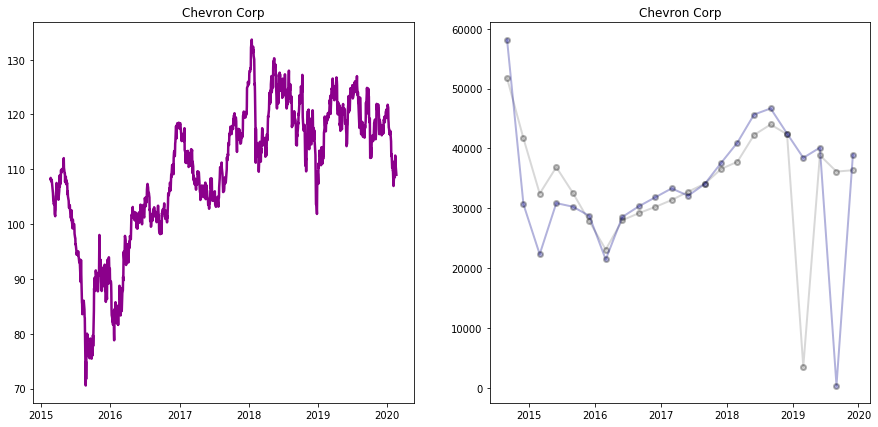

In [23]:
# Requirement 1
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7),subplot_kw = {'title' :companies_dropdown.value})


ax1.plot(data3.date,data3.open,
       linewidth=2.5,color='darkmagenta',label=2014)


ax2.plot(df.Period_End,df.Revenue2,
        linewidth=2,
       color='grey',
       alpha=0.3,
        marker = 'o', 
        markersize = 5,
        markeredgecolor = 'black',
        markeredgewidth = 2)

ax2.plot(df.Period_End,df.Forecast_Revenue,
        linewidth=2,
       color='darkblue',
       alpha=0.3,
        marker = 'o', 
        markersize = 5,
        markeredgecolor = 'black',
        markeredgewidth = 2)




In [ ]:
#Falta crear dos csv con los resultados del webscraping y de la API